In [2]:
%matplotlib inline

In [23]:
import numpy as np
import pandas as pd
import pickle as pkl
from itertools import product
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tqdm import tqdm
from matplotlib import pyplot as plt
from datetime import timedelta, datetime
from joblib import delayed, Parallel
from copy import copy

from core import  do_simulation
from helpers import Params, T, get_T1_and_T2, R0, plot_total, DATE_FORMAT, total_to_csv,  save_to_json, save_bundle

from const import STATE, COLORS, NUM_STATES,  STATES


In [16]:
p0_time = pkl.load(open('output/p0_time.pkl', 'rb'))
lockdown_time = T('23/01/2020')
days_before_ld  = (lockdown_time -  p0_time).days
params_before = pkl.load(
    open('output/params_before_lockdown.pkl', 'rb')
)

params_after = pkl.load(
    open('output/params_after_lockdown.pkl', 'rb')
)

bed_info = pkl.load(open('data/bed_info.pkl', 'rb'))

infection_factor = 1.999881671966743

In [17]:
bed_info

[(0, 3000),
 (57, 1000),
 (63, 6000),
 (67, 1000),
 (70, 2000),
 (74, 6000),
 (80, 11000),
 (84, 11000)]

In [18]:
event_date = T('20/01/2020')
days_before_event = (event_date - p0_time).days
days_before_event

52

In [31]:
total_days = 360

def one_run(event_factor):
    alpha_list = [
        (0, params_before.alpha),
        (days_before_event, event_factor * params_before.alpha),
        (days_before_ld, params_after.alpha)
    ]
    beta_list = [
        (0, params_before.beta),
        (days_before_event, params_before.beta),
        (days_before_ld, params_after.beta)
    ]

    p = Params(
        alpha=alpha_list,
        beta=beta_list,
        stages=[days_before_event, days_before_ld],
        initial_num_E=1,
        initial_num_I=0,
        initial_num_M=0
    )

    total, delta, increase, stats = do_simulation(total_days, bed_info, p, p0_time=p0_time)
    bundle = [total, delta, increase]
    return event_factor, bundle, stats

In [32]:
factors = np.arange(1, 1.251, step=0.05)
#  factors = np.arange(1, 9, step=1)
rows = Parallel(n_jobs=-1)(delayed(one_run)(factor) for factor in factors)

factor = 1.0
['29/11/19' '09/02/20' '21/04/20' '02/07/20' '12/09/20' '23/11/20']
factor = 1.05
['29/11/19' '09/02/20' '21/04/20' '02/07/20' '12/09/20' '23/11/20']
factor = 1.1
['29/11/19' '09/02/20' '21/04/20' '02/07/20' '12/09/20' '23/11/20']
factor = 1.1500000000000001
['29/11/19' '09/02/20' '21/04/20' '02/07/20' '12/09/20' '23/11/20']
factor = 1.2000000000000002
['29/11/19' '09/02/20' '21/04/20' '02/07/20' '12/09/20' '23/11/20']
factor = 1.2500000000000002
['29/11/19' '09/02/20' '21/04/20' '02/07/20' '12/09/20' '23/11/20']


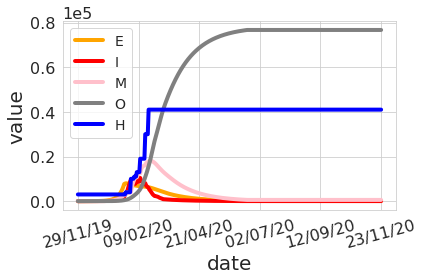

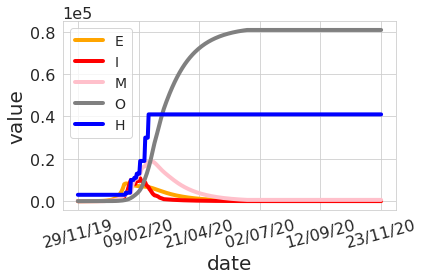

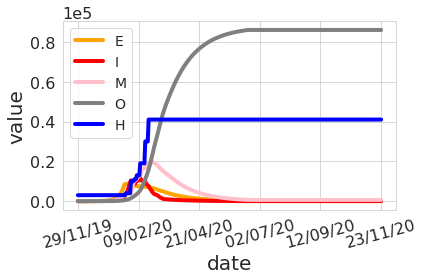

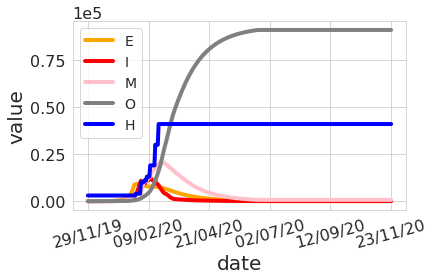

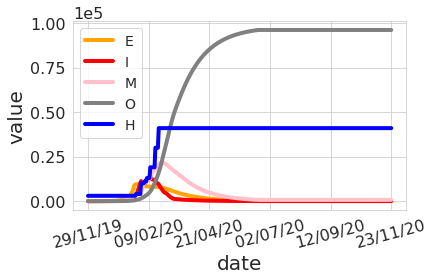

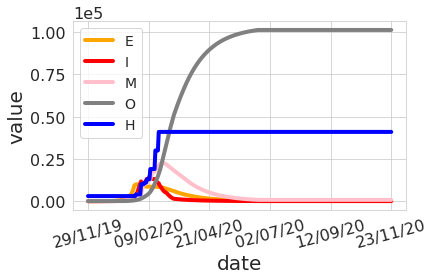

In [38]:
for event_factor, bundle, stats in rows:    
    print('factor =', event_factor)
    fig, ax = plot_total(bundle[0], p0_time, total_days)
    
    fig.savefig(f'figs/public-event/{event_factor}.pdf')
    event_factor = '{:.2f}'.format(event_factor)
    save_bundle(bundle, p0_time, total_days, f'output/tbl/public-event/{event_factor}/')
    save_to_json(stats, f'output/tbl/public-event/{event_factor}/stats.txt')    

In [22]:
df = pd.DataFrame(r0_rows, columns=['factor', 'before  event', 'after event', 'after lockdown'])
df
df.to_csv('output/tbl/public-event/r0.csv', index=None)